# Contagem de salgadinhos sortidos em caixas mistas

* **Vicente Knobel (202505144)**
* **Luiz Gustavo Coutinho Xavier (201905959)**

Neste notebook é apresentada a solução de um problema de visão computacional aplicado a indústria de alimentos, como requisitos para a disciplina **INE410121 - Visão Computacional**. O projeto consiste na aplicação de algoritmos clássicos de visão computacional e redes neurais artificiais para solução do problema de contagem de salgadinhos sortidos em caixas mistas. Em nossa melhor solução com o modelo pré-treinado YoLo v7, foi possível identificar corretamente diversas classes de salgadinhos em fotografias diversas de caixas, obtendo YY de acurácia em nosso dataset.


## Descrição do problema
O problema escolhido para atividade consiste na identificação de salgadinhos em caixas sortidas, adotando como exemplo encomendas de salgados produzidas por uma padaria local. Apesar de considerar a produção de um comércio específico, o problema estende-se a indústria de alimentos de modo geral, ao permitir a separação de encomendas de forma mais ágil assegurando controle de qualidade, especialmente em períodos de maior demanda de produção. Caixas sortidas são usualmente encomendadas com 4 ou 5 classes de salgados distintos, e possuem um tamanho padrão para conter um máximo de até 100 salgados. Para o escopo de problema definido neste trabalho, considera-se a existência das seguintes classes:

* Croquete de carne
* Coxinha de frango
* Empada folhada
* Sanduíche colorido
* Sanduíche aberto (canapé de salame com palito acima)
* Canudinho

É importante destacar a similaridade entre classes de salgadinhos no que diz respeito a sua cor e formato, o que representa um maior desafio na resolução do problema. Croquetes de carne apesar de majoritariamente marrons, possuem pigmentos pastéis da mesma cor das coxinhas devido a farinha utilizada em sua fabricação. Coxinhas e empadas também possuem grande similaridade de formato e cor.

As imagens do dataset se encontram disponíveis no diretório **/dataset**, totalizando 21 imagens. Diversas combinações de organizações com as seis classes de salgadinhos foram exploradas, incluindo organizações mais simples com somente uma classe. As imagens foram capturadas em alta resolução ($4032 \times 3024$) por uma câmera de celular

## Abordagem 1: segmentação simples
Como primeira solução, foi implementado um pipeline simples de processamento de imagem utilizando algoritmos clássicos de visão computacional com o objetivo de identificar uma classe de salgadinhos por vez. Cada uma das etapas é descrita como segue, seguido de sua respectiva implementação:

### 1.1. Inicialização e Carregamento de Imagem

Nesta primeira etapa são somente definidas algumas funções auxiliares para o carregamento e visualização de imagens. A função `load_image()` realiza a leitura de arquivos de imagem utilizando a biblioteca OpenCV e efetua a conversão do espaço de cores de BGR para RGB. A imagem original é armazenada nas variáveis globais `ORIGINAL_IMG` e `PIPELINE_IMG`, servindo como ponto de referência inicial para todas as operações subsequentes do pipeline de processamento. A função `show_2_images()` facilita a comparação lado a lado de duas imagens processadas, utiliza subplots do Matplotlib.

In [1]:
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import cv2
import numpy as np


def load_image(source):
    try:
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    except Exception as e:
        print(f"could not load image, err: {e}")
        return None


def show_2_images(image1, image2, title1, title2):
    _, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title(title1)

    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title(title2)

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'
ORIGINAL_IMG = load_image(IMAGE_PATH)
PIPELINE_IMG = ORIGINAL_IMG

### 1.2. Segmentação por Cor no Espaço HSV

A segmentação por cor constitui a etapa inicial de isolamento de regiões de interesse no pipeline. Esta implementação converte a imagem para o espaço de cor HSV, mais apropriado para segmentação baseada em tonalidade em comparação ao espaço RGB, e aplica operações de thresholding binárias definidas por limites inferiores e superiores de cada canal.

O método `cv2.inRange()` efetua o thresholding bidirecional, produzindo uma máscara binária onde pixels dentro do intervalo especificado recebem valor 255 (branco) e fora do intervalo recebem 0 (preto). Os limiares foram empiricamente calibrados para isolar a cor-alvo do objeto de interesse, neste caso correspondendo a tonalidades na faixa de marrom definida pelos valores `[8, 130, 10]` a `[24, 180, 140]`.

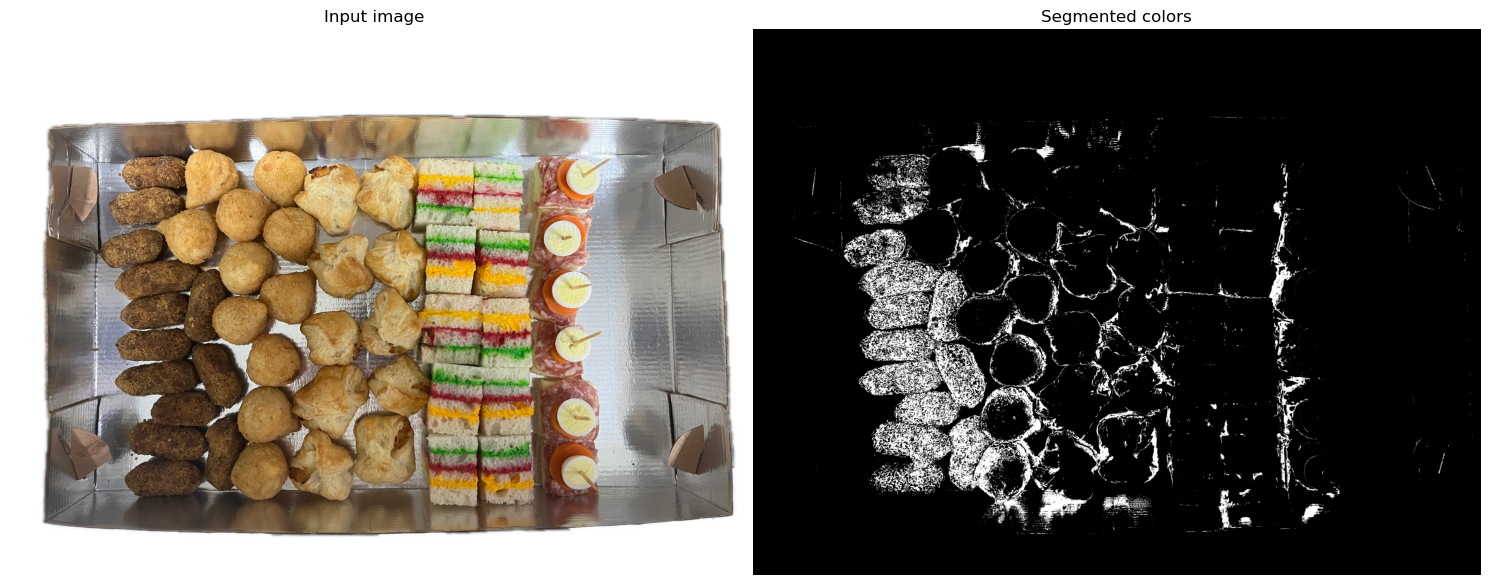

In [2]:
def segment_by_color(image, lower_threshold, upper_threshold):
    global PIPELINE_IMG
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    PIPELINE_IMG = cv2.inRange(hsv_image, lower_threshold, upper_threshold)
    #PIPELINE_IMG = cv2.bitwise_and(PIPELINE_IMG, image, mask=mask)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Segmented colors')


lower_t = np.array([8, 130, 10])
upper_t = np.array([24, 180, 140])

segment_by_color(PIPELINE_IMG, lower_t, upper_t)

### 1.3. Operações Morfológicas de Fechamento

A operação de fechamento (closing) é uma técnica de processamento morfológico que combina dilatação seguida de erosão, com o objetivo de preencher pequenas cavidades e remoção de ruído na máscara binária resultante da segmentação. Especificamente, a dilatação expande regiões brancas, preenchendo gaps internos, enquanto a erosão subsequente restaura a imagem ao tamanho original. O kernel estruturante define a vizinhança considerada na operação; neste caso, utiliza-se um kernel retangular $7 \times 7$.

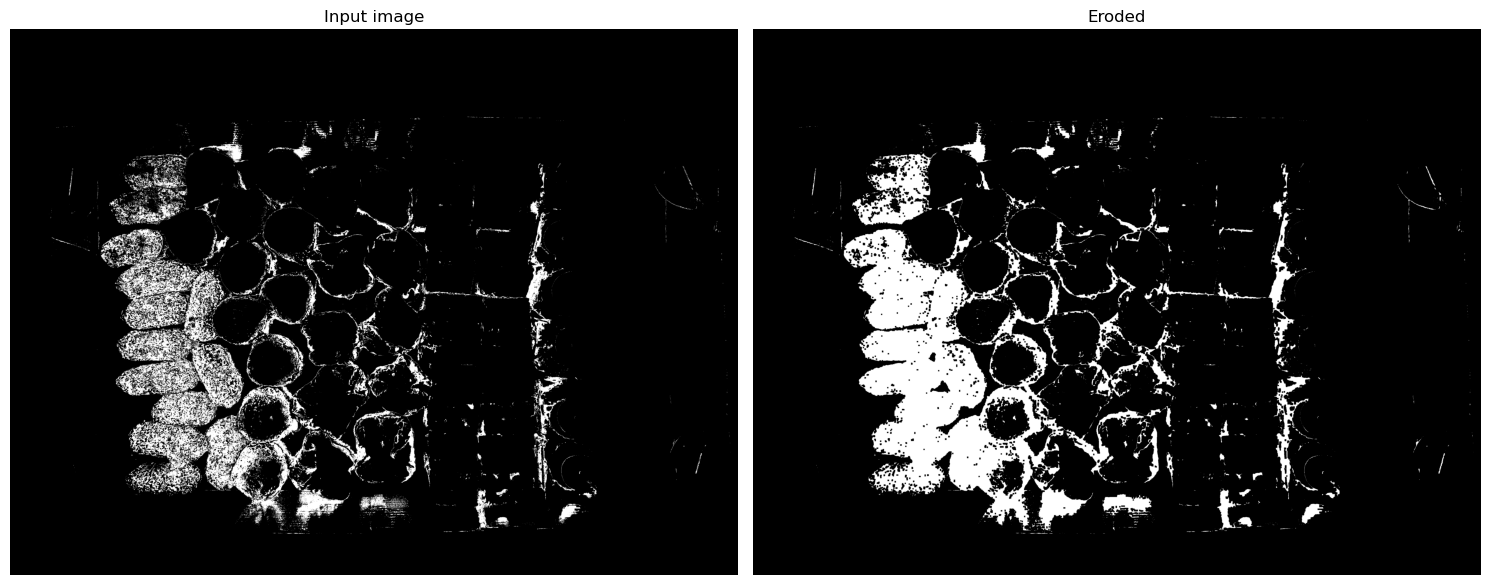

In [12]:
def apply_closing(image, kernel_size, iterations):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    #PIPELINE_IMG = cv2.dilate(gray_image, kernel, iterations=iterations)
    #PIPELINE_IMG = cv2.erode(PIPELINE_IMG, kernel, iterations=iterations)
    PIPELINE_IMG = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Eroded')


apply_closing(image=PIPELINE_IMG, kernel_size=(7,7), iterations=1)

### 1.4. Detecção de Bordas via Algoritmo de Canny

A detecção de bordas utilizando o algoritmo de Canny representa uma etapa crítica na identificação de contornos de objetos e estruturas. Este método aplica inicialmente um filtro bilateral `cv2.bilateralFilter()` para suavização seletiva com preservação de bordas, evitando tanto a amplificação de ruído quanto a atenuação excessiva de transições intensas. Os parâmetros do filtro (diâmetro=50, sigma de cor=90, sigma de espaço=90) foram calibrados para manter nitidez enquanto reduz artefatos de ruído.

O resultado é um mapa binário de bordas com precisão sub-pixel, onde apenas pixels que representam mudanças significativas de intensidade são ativados. Este mapa é essencial para operações subsequentes de detecção de formas geométricas, como a identificação de contornos e ajuste de elipses, sendo robusto a variações de escala e rotação.

Posteriormente, o algoritmo de Canny calcula-se o gradiente da imagem usando operadores Sobel, aplica-se supressão não-máxima para afinamento de bordas e aplica-se thresholding por histerese com dois níveis de threshold (15 para inferior, 45 para superior). Este duplo threshold reduz falsas detecções mantendo bordas fracas conectadas a bordas fortes, melhorando a continuidade dos contornos detectados.

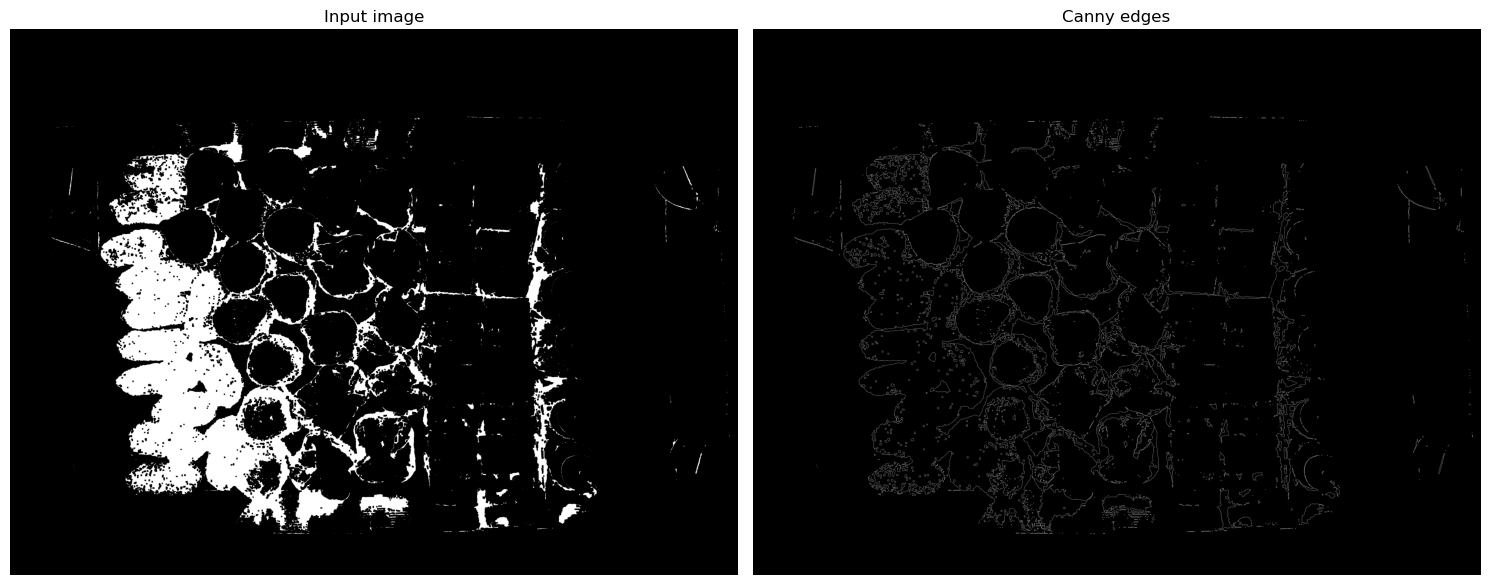

In [13]:
def apply_canny(image, threshold1, threshold2, apertureSize, L2gradient):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blurred_image = cv2.bilateralFilter(gray_image, 50, 90, 90)
    #blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    PIPELINE_IMG = cv2.Canny(blurred_image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient) 

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Canny edges')


# NOTE: Original image best with gaussian blurred at 65/195 or bilaterealFilter at 15/45
#apply_canny(image=ORIGINAL_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

apply_canny(image=PIPELINE_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

### 1.5. Detecção e Contagem de Elipses

Esta seção implementa duas abordagens complementares para detecção de elipses, cada uma com características distintas de robustez e eficiência computacional. A primeira abordagem utiliza a Transformada de Hough para elipses (`hough_ellipse`), método robusto baseado em votação acumulativa em espaço paramétrico. Este método verifica múltiplas combinações de parâmetros da elipse (centro, semieixos maior/menor, orientação) e acumula votos para configurações coerentes com a imagem. Embora seja altamente robusto a oclusões parciais e ruído, apresenta elevado custo computacional, com complexidade que cresce exponencialmente com a dimensionalidade do espaço de parâmetros.

Esta segunda abordagem demonstra eficiência computacional significativamente superior, apresentando complexidade linear com o número de contornos e operações locais de ajuste. Consequentemente, é preferível para aplicações em tempo real, processamento de imagens de grande resolução ou quando o número de elipses esperadas é moderado. Ambas as implementações marcam as elipses detectadas com contornos verdes na imagem de saída.

A segunda abordagem, implementada em `count_ellipses_contours()`, emprega análise sequencial de contornos com ajuste de elipses via mínimos quadrados. O método detecta contornos na imagem binária, e para cada contorno com número suficiente de pontos, ajusta-se uma elipse utilizando `cv2.fitEllipse()`. Os candidatos são então filtrados mediante critérios geométricos rigorosos: (i) área mínima, (ii) razão entre área do contorno e área da elipse ajustada, e (iii) razão entre semieixos da elipse, rejeitando formas muito alongadas ou muito pequenas.

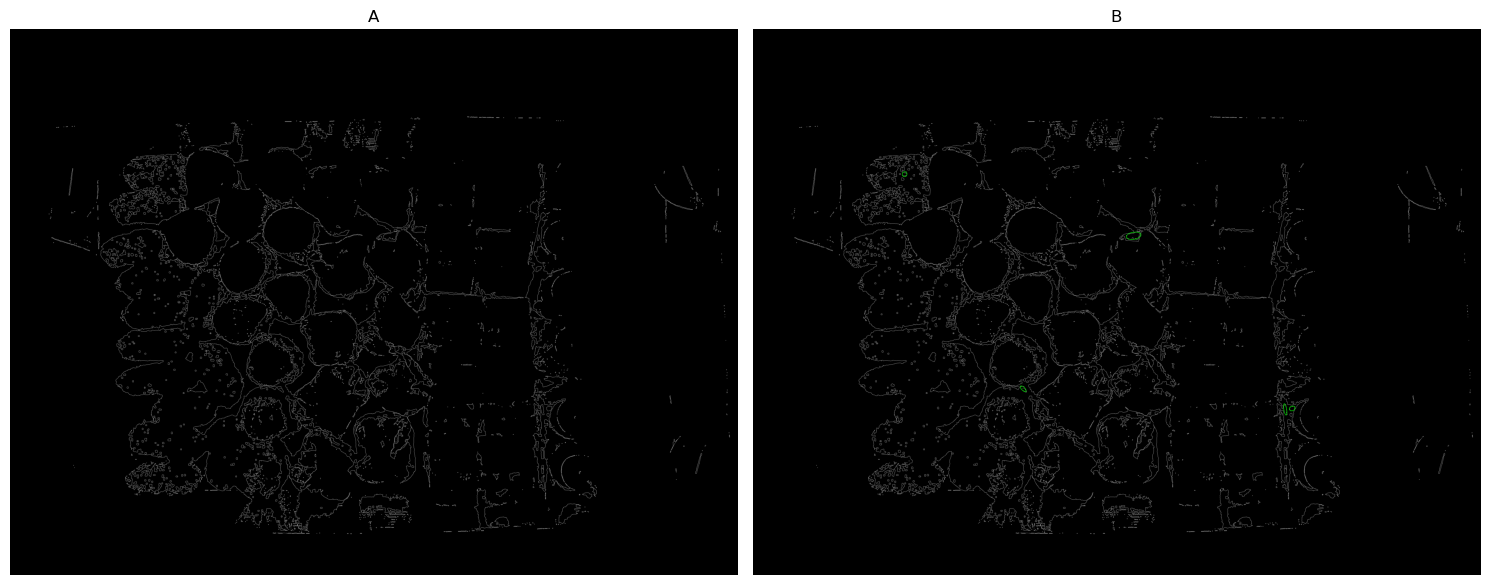

detected: 5


In [14]:
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter


def count_ellipses_hough(image, accuracy=20, threshold=120, min_size=10, max_size=120, top_n=20):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    result = hough_ellipse(image, accuracy=accuracy, threshold=threshold,
                           min_size=min_size, max_size=max_size)
    if result.size == 0:
        return 0, image.copy()

    # result is a structured array; sort by accumulator and take top candidates
    result.sort(order='accumulator')
    best = result[-top_n:]

    count = 0
    for r in best:
        yc, xc, a, b = [int(round(x)) for x in (r['yc'], r['xc'], r['a'], r['b'])]
        orientation = r['orientation']
        if a <= 0 or b <= 0:
            continue
        
        rr, cc = ellipse_perimeter(yc, xc, a, b, orientation)
        # clamp coords and draw
        rr = np.clip(rr, 0, PIPELINE_IMG.shape[0]-1)
        cc = np.clip(cc, 0, PIPELINE_IMG.shape[1]-1)
        PIPELINE_IMG[rr, cc] = (0, 255, 0)
        count += 1

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Hough ellipse')
    return count


def count_ellipses_contours(image, area_min=500, area_ratio_tol=0.9, axis_ratio_max=5.0):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    _, th = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #mask = np.zeros_like(image)
    
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_min or len(cnt) < 5:
            continue
        
        ellipse = cv2.fitEllipse(cnt)
        (MA, ma) = ellipse[1]
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        ellipse_area = np.pi * a * b
        if ellipse_area <= 0:
            continue
        
        area_ratio = area / ellipse_area
        axis_ratio = (MA / ma) if ma > 0 else 999
        
        if area_ratio >= area_ratio_tol and axis_ratio <= axis_ratio_max:
            cv2.ellipse(out, ellipse, (0,255,0), 2)
            #cv2.drawContours(mask, [cnt], -1, 255, -1)
            count += 1

    return count, out


# executed for 14min and nothing, too slow!
#count = count_ellipses_hough(PIPELINE_IMG)


count, out = count_ellipses_contours(PIPELINE_IMG)
show_2_images(PIPELINE_IMG, out, 'A', 'B')

print('detected:', count)

### 1.6. Visualização de Características Utilizando Histograma de Gradientes Orientados (HoG)

O Histograma de Gradientes Orientados (HoG) constitui um descritor de características robusto capaz de capturar informações estruturais, morfológicas e de textura da imagem. Este método divide a imagem em células não-sobrepostas (neste caso, $16 \times 16$ pixels), computa histogramas de orientações de gradientes para cada célula em 8 direções equiespaçadas, normalizando posteriormente os blocos compostos por células adjacentes. A normalização por bloco reduz a dependência a variações de iluminação, aumentando invariância a mudanças de contraste.

O método é amplamente utilizado em reconhecimento de objetos, detecção de pedestres, classificação de padrões e outras tarefas de visão computacional moderna, servindo tanto como descritor para aprendizado de máquina quanto para análise interpretável de conteúdo visual. No contexto deste pipeline, a visualização HoG permite validar visualmente a qualidade das transformações anteriores e a relevância das características estruturais detectadas.

A visualização HoG produz uma representação que enfatiza estruturas e bordas dominantes presentes na imagem, onde as orientações de gradiente predominantes em cada região são visualizadas como linhas ou vetores. Esta representação é particularmente útil para compreensão qualitativa das características principais da imagem e validação de processamentos anteriores, permitindo identificar regiões de alta atividade estrutural versus regiões homogêneas.

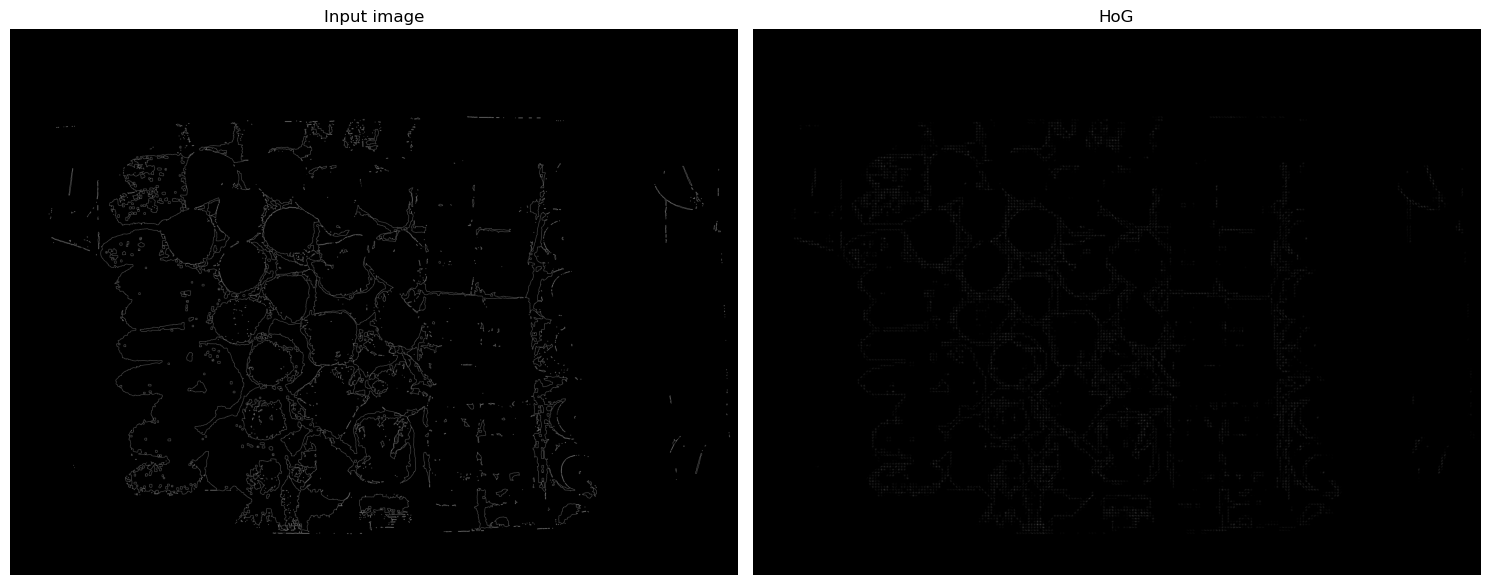

In [ ]:
from skimage.feature import hog


def apply_hog(image, cell_size):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    channel_axis = None
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        channel_axis = -1

    _, PIPELINE_IMG = hog(gray_image, orientations=8, pixels_per_cell=(cell_size, cell_size),
        cells_per_block=(1, 1), visualize=True, channel_axis=channel_axis)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'HoG')


apply_hog(PIPELINE_IMG, 16)    